In [ ]:
!pip install pot

Archive:  WGAN.zip
   creating: WGAN/
  inflating: WGAN/utils.py           
   creating: WGAN/__pycache__/
  inflating: WGAN/__pycache__/Losses.cpython-37.pyc  
  inflating: WGAN/__pycache__/utils.cpython-37.pyc  
  inflating: WGAN/__pycache__/NNs.cpython-37.pyc  
  inflating: WGAN/NNs.py             
  inflating: WGAN/Losses.py          
     |████████████████████████████████| 440kB 5.7MB/s 


In [ ]:
from WGAN.NNs import DiscriminatorMLP, DiscriminatorConvNet
from WGAN.utils import divide_by_classes, Trainer
from WGAN.Losses import GPLoss, WCLoss, WeightClipper, CEpsilonLoss, CLoss, LPLoss

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.utils as vutils

from torch.autograd import Variable
import torch.autograd as autograd

import torch.nn as nn
import torch.nn.functional as F
import torch

import numpy as np
from tqdm.notebook import tqdm

from itertools import product

In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize((32, 32)),
    ]
)

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

import MNIST

In [ ]:
datasets_names = ['CIFAR10', 'MNIST']
datasets_check = {'CIFAR10': (datasets.CIFAR10(root='cifar/', transform=transform, download=True, train=True),
                        datasets.CIFAR10(root='cifar/', transform=transform, download=True, train=False)),
            'MNIST': (datasets.MNIST(root = './', train=True, download=True, transform=transform),
                      datasets.MNIST(root = './', train=False, download=True, transform=transform))}

batch_sizes = list(product([64, 512], [64, 512]))

models = []

dataset_name = 'MNIST'
dataset_train, dataset_test = datasets_check[dataset_name]
N, M = batch_sizes[0]

train_part1, train_part2 = divide_by_classes(dataset_train, N, cifar=False)
test_part1, test_part2 = divide_by_classes(dataset_test, M, cifar=False)

check_image = next(iter(train_part1))

epochs = 20
num_of_channels = check_image.size(1)
image_size = check_image.size(2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

trainer = Trainer(
    criterion=WCLoss(),
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -1.3685083
Val epoch 0 , Stability : -0.10201721



Val epoch 1 , Mean error : -1.2502961
Val epoch 1 , Stability : -0.1292948



Val epoch 2 , Mean error : -1.1317255
Val epoch 2 , Stability : -0.12939784



Val epoch 3 , Mean error : -1.0285739
Val epoch 3 , Stability : -0.097427757



Val epoch 4 , Mean error : -0.94079758
Val epoch 4 , Stability : -0.086188569



Val epoch 5 , Mean error : -0.86485708
Val epoch 5 , Stability : -0.079747283



Val epoch 6 , Mean error : -0.79933686
Val epoch 6 , Stability : -0.071138327



Val epoch 7 , Mean error : -0.74168614
Val epoch 7 , Stability : -0.067563977



Val epoch 8 , Mean error : -0.69149248
Val epoch 8 , Stability : -0.06155602



Val epoch 9 , Mean error : -0.64803255
Val epoch 9 , Stability : -0.058652871



Val epoch 10 , Mean error : -0.60930265
Val epoch 10 , Stability : -0.058200067



Val epoch 11 , Mean error : -0.57463146
Val epoch 11 , Stability : -0.061318346



Val epoch 12 , Mean error : -0.5432954
Val epoch 12 , Stability : -0.055980533



Val epoch 13 , Mean error : -0.51529037
Val epoch 13 , Stability : -0.054428627



Val epoch 14 , Mean error : -0.48962996
Val epoch 14 , Stability : -0.05437648



Val epoch 15 , Mean error : -0.46628615
Val epoch 15 , Stability : -0.05369558



Val epoch 16 , Mean error : -0.44453686
Val epoch 16 , Stability : -0.055048203



Val epoch 17 , Mean error : -0.42369839
Val epoch 17 , Stability : -0.058198644



Val epoch 18 , Mean error : -0.40401045
Val epoch 18 , Stability : -0.055369406



Val epoch 19 , Mean error : -0.38534483
Val epoch 19 , Stability : -0.055012361


In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

Average error for mlp is: 0.407+-0.018


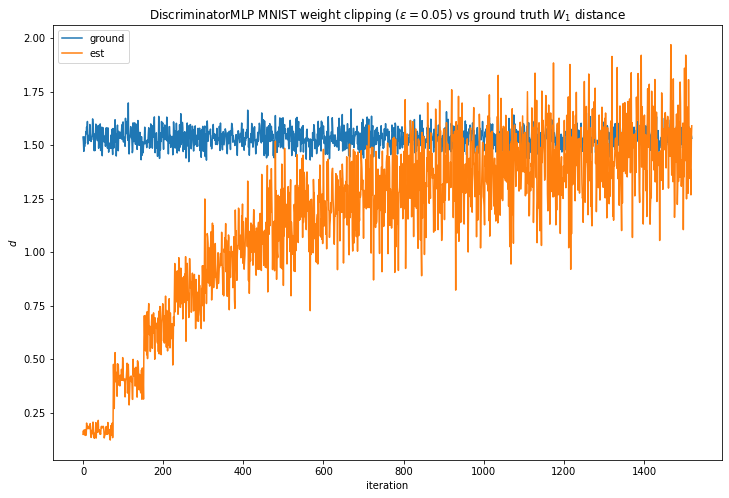

In [ ]:
with PdfPages(r'{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} weight clipping $(\epsilon = {})$ vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name, 0.05));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = GPLoss(lambda_gp=10)
criterion.optimizer_params['lr'] = 0.005

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -1.6732316
Val epoch 0 , Stability : -0.5307383



Val epoch 1 , Mean error : -1.8564133
Val epoch 1 , Stability : 0.20583437



Val epoch 2 , Mean error : -1.9495381
Val epoch 2 , Stability : 0.36559914



Val epoch 3 , Mean error : -1.8440612
Val epoch 3 , Stability : -0.12076813



Val epoch 4 , Mean error : -1.7971205
Val epoch 4 , Stability : -0.034305838



Val epoch 5 , Mean error : -1.7588671
Val epoch 5 , Stability : -0.06470845



Val epoch 6 , Mean error : -1.7500727
Val epoch 6 , Stability : 0.059204659



Val epoch 7 , Mean error : -1.7302029
Val epoch 7 , Stability : -0.028047384



Val epoch 8 , Mean error : -1.7210242
Val epoch 8 , Stability : 0.03496484



Val epoch 9 , Mean error : -1.7324281
Val epoch 9 , Stability : 0.23336022



Val epoch 10 , Mean error : -1.7213902
Val epoch 10 , Stability : 0.014719919



Val epoch 11 , Mean error : -1.7050115
Val epoch 11 , Stability : -0.054083126



Val epoch 12 , Mean error : -1.6959078
Val epoch 12 , Stability : 0.014275316



Val epoch 13 , Mean error : -1.6855524
Val epoch 13 , Stability : -0.016517293



Val epoch 14 , Mean error : -1.6762345
Val epoch 14 , Stability : -0.022021237



Val epoch 15 , Mean error : -1.6703312
Val epoch 15 , Stability : 0.016790032



Val epoch 16 , Mean error : -1.6605661
Val epoch 16 , Stability : -0.049989394



Val epoch 17 , Mean error : -1.6526816
Val epoch 17 , Stability : -0.035307312



Val epoch 18 , Mean error : -1.6452153
Val epoch 18 , Stability : -0.038419245



Val epoch 19 , Mean error : -1.6406221
Val epoch 19 , Stability : 0.012885594


Average error for mlp is: 1.641+-0.009


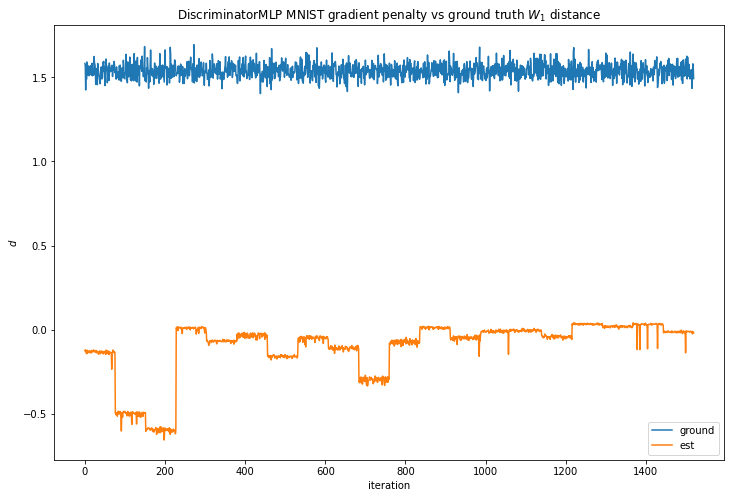

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} gradient penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = LPLoss(lambda_gp=10)
criterion.optimizer_params['lr'] = 0.001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -1.5105208
Val epoch 0 , Stability : -0.0051257937



Val epoch 1 , Mean error : -1.5043226
Val epoch 1 , Stability : -0.0060459977



Val epoch 2 , Mean error : -1.5030725
Val epoch 2 , Stability : 0.0010098298



Val epoch 3 , Mean error : -1.5004553
Val epoch 3 , Stability : -0.003901781



Val epoch 4 , Mean error : -1.4985226
Val epoch 4 , Stability : -0.0029073161



Val epoch 5 , Mean error : -1.4975176
Val epoch 5 , Stability : 0.00010914684



Val epoch 6 , Mean error : -1.4969303
Val epoch 6 , Stability : -0.0021553595



Val epoch 7 , Mean error : -1.496613
Val epoch 7 , Stability : 0.00091747855



Val epoch 8 , Mean error : -1.495669
Val epoch 8 , Stability : -0.0024638891



Val epoch 9 , Mean error : -1.4951702
Val epoch 9 , Stability : -0.0020398772



Val epoch 10 , Mean error : -1.4943946
Val epoch 10 , Stability : -0.0019331894



Val epoch 11 , Mean error : -1.4939962
Val epoch 11 , Stability : -0.0009613565



Val epoch 12 , Mean error : -1.4937716
Val epoch 12 , Stability : 0.0013677935



Val epoch 13 , Mean error : -1.4931269
Val epoch 13 , Stability : -0.0014196579



Val epoch 14 , Mean error : -1.4927014
Val epoch 14 , Stability : -0.0010471172



Val epoch 15 , Mean error : -1.4922906
Val epoch 15 , Stability : -0.0017044487



Val epoch 16 , Mean error : -1.4919048
Val epoch 16 , Stability : -0.0015423764



Val epoch 17 , Mean error : -1.4918677
Val epoch 17 , Stability : 0.00066415652



Val epoch 18 , Mean error : -1.491518
Val epoch 18 , Stability : -0.0021366732



Val epoch 19 , Mean error : -1.4910961
Val epoch 19 , Stability : -0.0020488022


Average error for mlp is: 1.491+-0.002


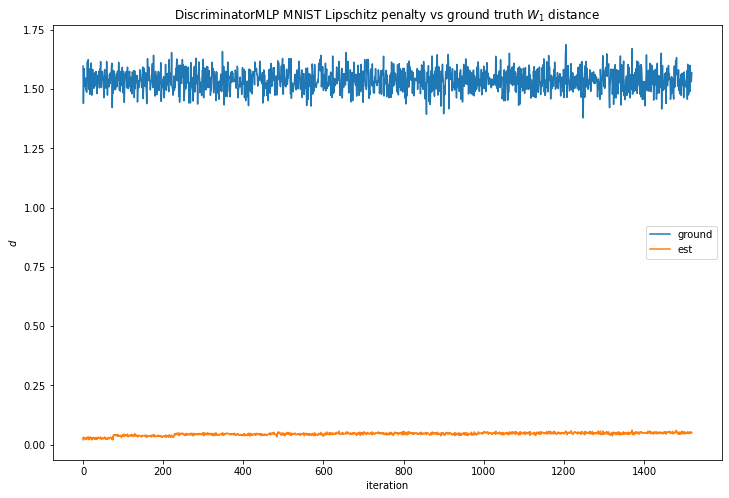

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} Lipschitz penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorMLP_MNIST_LPLoss.pdf /content/drive/MyDrive/Sk/ML/Project/MLP/MNIST

In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = CLoss()
criterion.optimizer_params['lr'] = 0.001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -0.062215687
Val epoch 0 , Stability : -0.0086904308



Val epoch 1 , Mean error : -0.060727838
Val epoch 1 , Stability : -0.0042369861



Val epoch 2 , Mean error : -0.060743106
Val epoch 2 , Stability : -0.0038375183



Val epoch 3 , Mean error : -0.061433538
Val epoch 3 , Stability : 0.0018943018



Val epoch 4 , Mean error : -0.061226998
Val epoch 4 , Stability : -0.0011746528



Val epoch 5 , Mean error : -0.060838848
Val epoch 5 , Stability : 0.00028191664



Val epoch 6 , Mean error : -0.06012571
Val epoch 6 , Stability : 0.0013160288



Val epoch 7 , Mean error : -0.059783635
Val epoch 7 , Stability : -0.0013108488



Val epoch 8 , Mean error : -0.05950051
Val epoch 8 , Stability : 0.00095895937



Val epoch 9 , Mean error : -0.059315773
Val epoch 9 , Stability : 0.0034048488



Val epoch 10 , Mean error : -0.059423826
Val epoch 10 , Stability : 0.0057913105



Val epoch 11 , Mean error : -0.059063648
Val epoch 11 , Stability : -0.0022007413



Val epoch 12 , Mean error : -0.059667918
Val epoch 12 , Stability : 0.0098990418



Val epoch 13 , Mean error : -0.059321003
Val epoch 13 , Stability : 0.00045405887



Val epoch 14 , Mean error : -0.059255444
Val epoch 14 , Stability : 0.00030847128



Val epoch 15 , Mean error : -0.059221519
Val epoch 15 , Stability : -0.00093629033



Val epoch 16 , Mean error : -0.059111624
Val epoch 16 , Stability : 0.0019744213



Val epoch 17 , Mean error : -0.058873783
Val epoch 17 , Stability : -0.0065409632



Val epoch 18 , Mean error : -0.058695904
Val epoch 18 , Stability : 0.00016752787



Val epoch 19 , Mean error : -0.058539152
Val epoch 19 , Stability : -0.0030505785


Average error for conv is: 0.059+-0.001


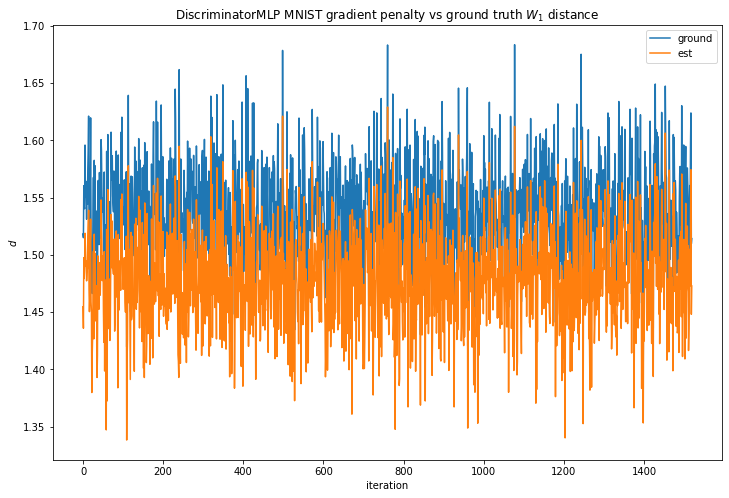

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} $c$-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 0.059+-0.001


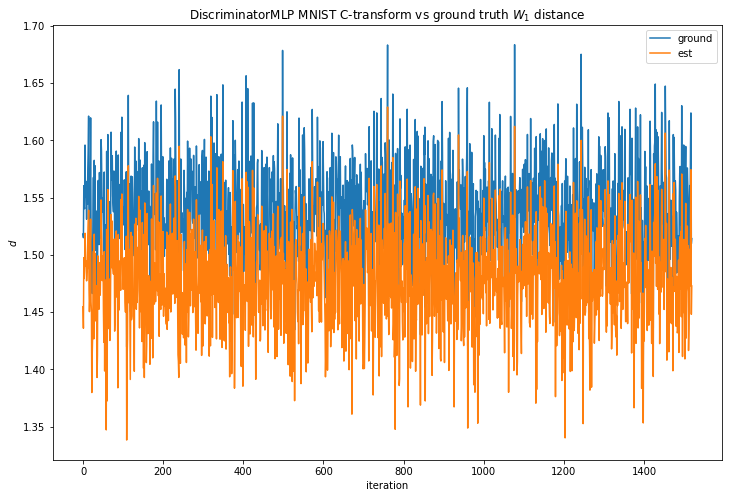

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} C-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorMLP_MNIST_CLoss.pdf /content/drive/MyDrive/Sk/ML/Project/MLP/MNIST

In [ ]:
discriminator = DiscriminatorMLP(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = CEpsilonLoss(12)
criterion.optimizer_params['lr'] = 0.0001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : 0.18043582
Val epoch 0 , Stability : 0.0063462935



Val epoch 1 , Mean error : 0.1813366
Val epoch 1 , Stability : 0.016431924



Val epoch 2 , Mean error : 0.18277114
Val epoch 2 , Stability : 0.017548906



Val epoch 3 , Mean error : 0.18320313
Val epoch 3 , Stability : 0.018366906



Val epoch 4 , Mean error : 0.18400368
Val epoch 4 , Stability : 0.019679708



Val epoch 5 , Mean error : 0.18459451
Val epoch 5 , Stability : 0.018952788



Val epoch 6 , Mean error : 0.18507738
Val epoch 6 , Stability : 0.01604604



Val epoch 7 , Mean error : 0.18570018
Val epoch 7 , Stability : 0.019059408



Val epoch 8 , Mean error : 0.18615768
Val epoch 8 , Stability : 0.016597921



Val epoch 9 , Mean error : 0.1866307
Val epoch 9 , Stability : 0.022268166



Val epoch 10 , Mean error : 0.18693535
Val epoch 10 , Stability : 0.016490159



Val epoch 11 , Mean error : 0.18730226
Val epoch 11 , Stability : 0.01752025



Val epoch 12 , Mean error : 0.18759196
Val epoch 12 , Stability : 0.021480305



Val epoch 13 , Mean error : 0.18778826
Val epoch 13 , Stability : 0.014626784



Val epoch 14 , Mean error : 0.18796371
Val epoch 14 , Stability : 0.019468149



Val epoch 15 , Mean error : 0.18819483
Val epoch 15 , Stability : 0.020680048



Val epoch 16 , Mean error : 0.18840993
Val epoch 16 , Stability : 0.018775811



Val epoch 17 , Mean error : 0.18854857
Val epoch 17 , Stability : 0.021411915



Val epoch 18 , Mean error : 0.18876529
Val epoch 18 , Stability : 0.019912061



Val epoch 19 , Mean error : 0.18901633
Val epoch 19 , Stability : 0.020901332


Average error for conv is: 0.189+-0.001


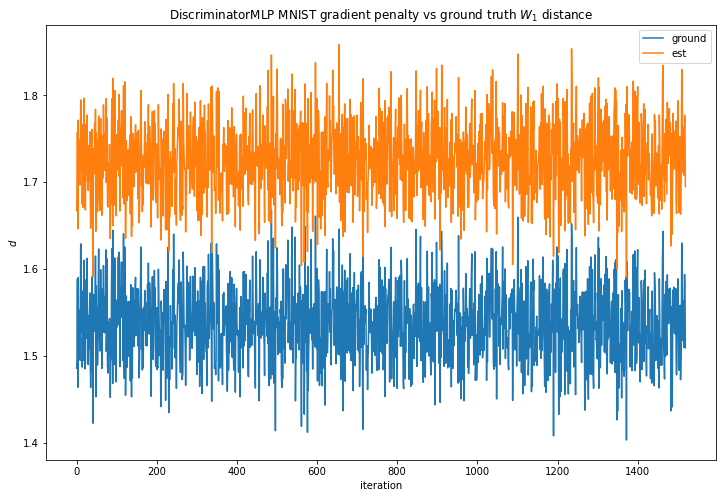

In [ ]:
import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

plt.figure(figsize=(12, 8));

plt.title(r"{} {} ($c, \epsilon$)-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
plt.plot(val_ground, label="ground");
plt.plot(val_dest, label="est");
plt.ylabel(r"$d$");
plt.xlabel("iteration")
plt.legend();
mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")

Average error for mlp is: 0.189+-0.001


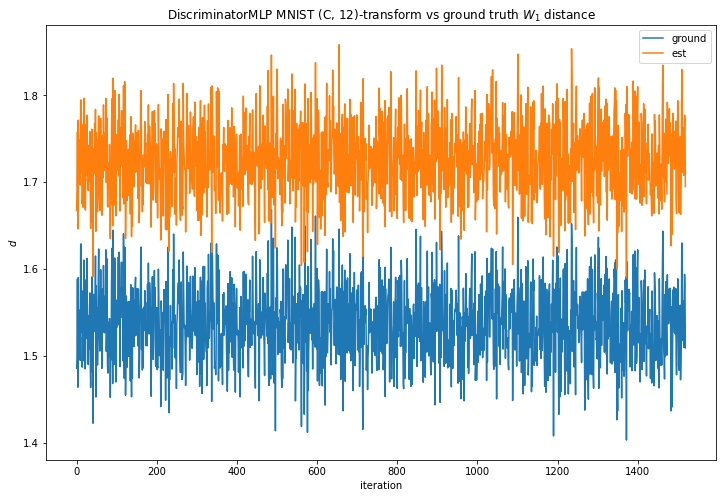

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} (C, 12)-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
!mv DiscriminatorMLP_MNIST_CEpsilonLoss.pdf /content/drive/MyDrive/Sk/ML/Project/MLP/MNIST